In [3]:
import numpy as np
import pickle
import pandas as pd
import math
from matplotlib import pylab as plt
from scipy import stats
%matplotlib inline
plt.rcParams['pdf.fonttype']=42
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams['axes.linewidth'] = 2 # set the value globally

In [4]:
with open('../Data/metabolomics_data_including_fit.pkl', 'r') as f:
    data = pickle.load(f)
# print data.keys()
# print 'dim1:', data['dim1']
# print 'dim2:', data['dim2']

#load growth rate dataframe = df
df = pd.read_excel('../Data/singleresource_data.xlsx', sheetname = 'avg')
dfstderr = pd.read_excel('../Data/singleresource_data.xlsx', sheetname = 'stderr')
print 'single resource growth rates:'
print df

#load molarity dataframe = mf
mf = pd.read_csv('../Data/molarity.txt', sep = '\t', index_col = 0)
mf = mf.sort_index()
print '\nstarting compound concentrations:'
print mf

#load amino acid percent of CDS dataframe and clean up 
pct = pd.read_excel('../Data/percent_AA_composition_genome.xlsx')
pct.columns = ['3B10', '9B05', 'L13']
pct = pct.drop(pct.index[0])

codes = {
    'W': 'tryptophan',
    'H': 'histidine',
    'M': 'methionine',
    'P': 'proline',
    'Q': 'glutamine',
    'R': 'arginine',
    'Y': 'tyrosine',
    'D': 'aspartate',
    'N': 'asparagine',
    'F': 'phenylalanine',
    'T': 'threonine',
    'S': 'serine',
    'A': 'alanine',
    'G': 'glycine',
    'V': 'valine',
    'K': 'lysine',
    'E': 'glutamate',
    'I': 'isoleucine',
    'L': 'leucine'
}

newidx = []

for comp in pct.index:
    for code in codes:
        if code in comp:
            newidx.append(codes[code])
pct.index = newidx
print '\namino acid composition of translated genome:'
print pct

single resource growth rates:
         compound      3B10      9B05       L13
0         leucine  0.045218  0.071403  0.064277
1   phenylalanine       NaN       NaN       NaN
2      isoleucine  0.095422  0.102436  0.110625
3      tryptophan       NaN       NaN       NaN
4      methionine       NaN       NaN       NaN
5         proline  0.102368  0.149167  0.135327
6          valine       NaN  0.083553  0.091078
7        tyrosine       NaN       NaN       NaN
8         glucose  0.217800  0.102216  0.115785
9         alanine  0.339886  0.305937  0.069963
10      threonine       NaN       NaN       NaN
11      glutamine  0.315376  0.279231  0.169036
12        glycine       NaN       NaN       NaN
13     asparagine  0.335349  0.203647  0.172692
14      histidine  0.339370       NaN  0.264821
15         serine       NaN       NaN  0.036640
16      glutamate  0.188674  0.185348  0.171980
17      aspartate  0.149137  0.234237  0.154423
18         lysine       NaN       NaN  0.079435
19       a

In [5]:
thalf = pd.read_excel('../Data/Calculated_Data.xlsx', sheetname = 'halfways_avg')
thalf_err = pd.read_excel('../Data/Calculated_Data.xlsx', sheetname = 'halfways_stderr')

# Ts = pd.read_excel('./Data.xlsx', sheetname = 'Ts_avg')
# Ts_err = pd.read_excel('./Data.xlsx', sheetname = 'Ts_stderr')

#load maxrate compound usage dataframt = rf
# maxrate = pd.read_excel('./Data.xlsx', sheetname = 'maxrate_avg')
# maxrate_stderr = pd.read_excel('./Data.xlsx', sheetname = 'maxrate_stderr')

# use max rates relative to OD
maxrate = pd.read_excel('../Data/Calculated_Data.xlsx', sheetname = 'maxrate_odnorm_avg')
maxrate_stderr = pd.read_excel('../Data/Calculated_Data.xlsx', sheetname = 'maxrate_odnorm_stderr')

# use max rates with units of mmol/hr  and relative to gCDW biomass
maxrate = pd.read_excel('../Data/Calculated_Data.xlsx', sheetname = 'maxrate_by_gcdw_mmol_avg')
maxrate_stderr = pd.read_excel('../Data/Calculated_Data.xlsx', sheetname = 'maxrate_by_gcdw_mmol_stderr')

In [6]:
colors=[
    'darkred',
    'red',
    'palevioletred',
    'violet',
    'magenta',
    'saddlebrown',
    'coral',
    'orange',
    'gold',
    'greenyellow',
    'darkkhaki',
    'lime',
    'green',
    'olivedrab',
    'darkcyan',
    'mediumaquamarine',
    'blue',
    'steelblue',
    'purple',
    'indigo',
]
def get_col(pval):
    #returns red if the p-value from the pearson's correlation calculation is less than .05
    return 'red' if pval < 0.05 else 'black'

In [7]:
#reorder moles table
moles = []
for k, comp in enumerate(thalf.index):
    for kk, comp2 in enumerate(mf.index):
        if comp.replace(' Results Final Conc.', '') == comp2:
            moles.append(mf.iloc[kk,1])
#             print comp.replace(' Results Final Conc.', ''), comp2

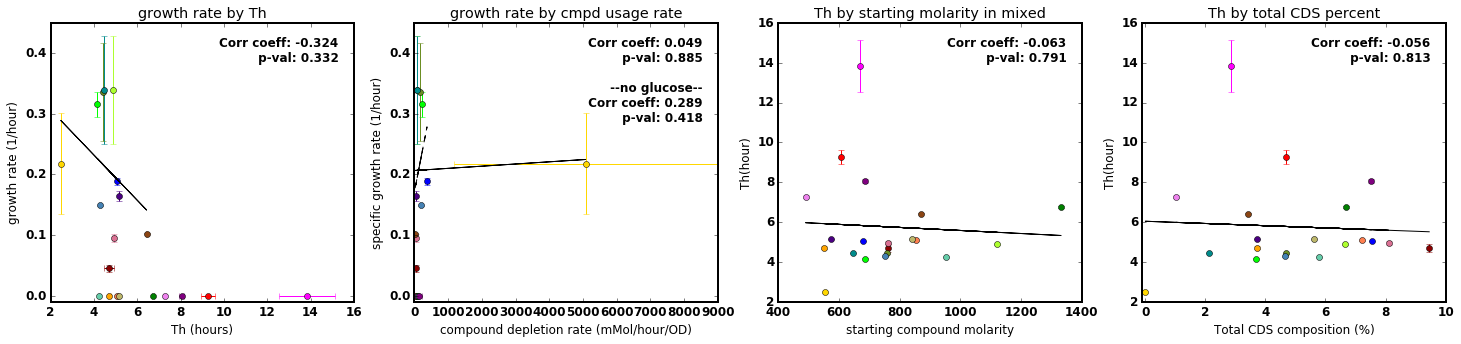

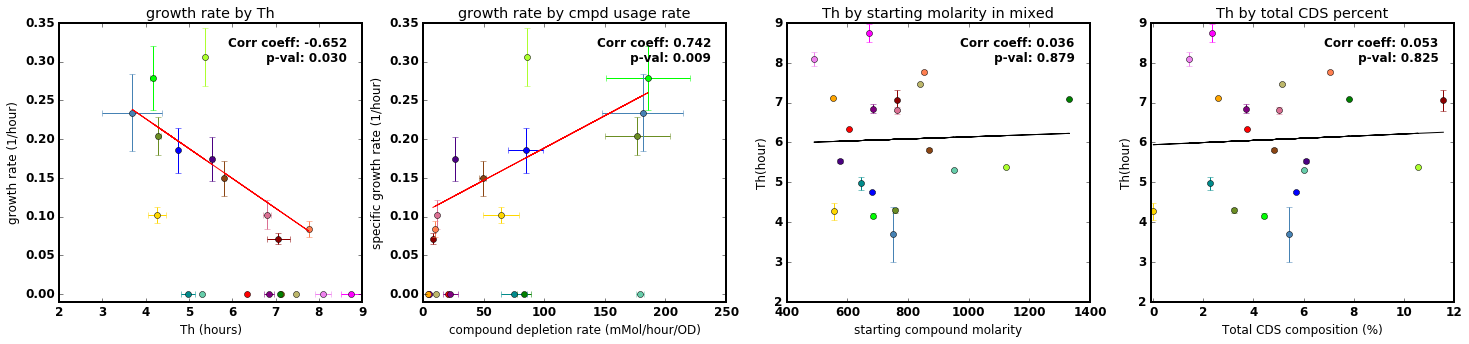

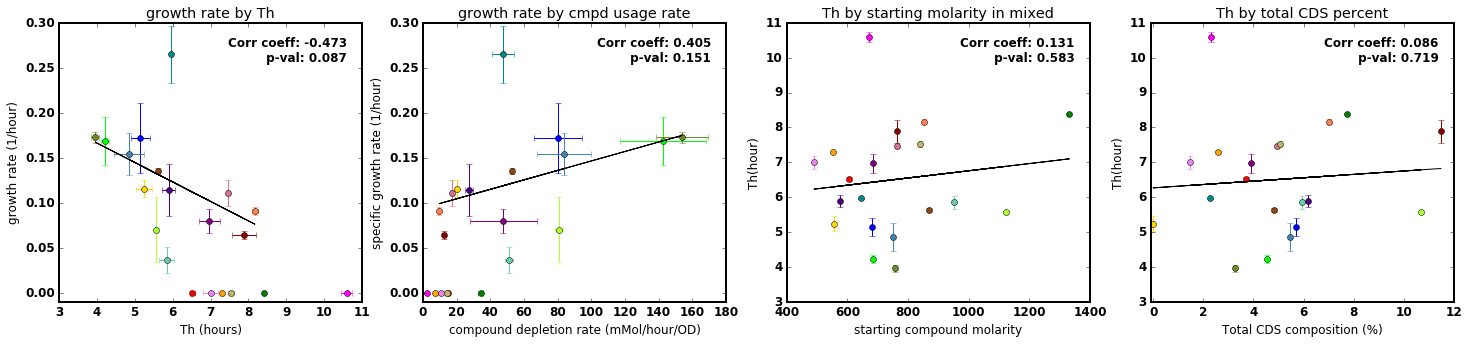

In [19]:
plots = ['3B10', '9B05', 'L13']

for i, name in enumerate(plots):
    fig, ax = plt.subplots(1,4)
    ax = ax.ravel()
    
    #reorder percent table
    percent = []
    for k, comp in enumerate(thalf.index):
        for kk, comp2 in enumerate(pct.index):
            if comp.replace(' Results Final Conc.', '') == 'glucose':
                percent.append(0)
                break
            elif comp.replace(' Results Final Conc.', '') == comp2:
                percent.append(pct.iloc[kk,i])
    
    #t-half
    Th = thalf[name[:4]]
    Th_err = thalf_err[name[:4]]
    
    #growth rate on individual compounds
    growth = df[name]
    growth_err = dfstderr[name]

    #max compound usage rate in mixed conditions
    cmprate = maxrate[name[:4]]# / 1000
    cmprate_err = maxrate_stderr[name[:4]]# / 1000
    
    #turn all nan into 0, for plotting
    growth_zed = growth.fillna(0)
    
    #make coordinates that ignore the NaNs, for correlations
    #to correlate growth rate with Th
    c_growth = growth[np.argwhere(~np.isnan(growth)).flatten()]
    c_Th = Th[np.argwhere(~np.isnan(growth)).flatten()]
    
    #to correlate max compound usage rate with growth rate
    c_cmprate = cmprate[np.argwhere(~np.isnan(growth)).flatten()]
    
    
    
    #plot the correlations
    ax[0].set_title('growth rate by Th')
    for j, blah in enumerate(Th):
        ax[0].errorbar(Th[j], growth_zed[j], 
                     xerr = Th_err[j], yerr = growth_err[j], 
                     fmt = 'o', color = colors[j], ecolor = colors[j])
    #get pearson correlation coefficient [0] and p-value [1]
    r_gth = stats.pearsonr(c_Th, c_growth)
    #make the trendline
    z = np.polyfit(c_Th, c_growth, 1)
    #convert to mx + b
    p = np.poly1d(z)
    #plot it
    ax[0].plot(c_Th, p(c_Th), color = get_col(r_gth[1]))
    ax[0].text(0.95, 0.95,
         'Corr coeff: %.3f\n p-val: %.3f' 
            %(r_gth[0], r_gth[1]),
        horizontalalignment = 'right', verticalalignment = 'top', transform = ax[0].transAxes)
    
    ax[0].set_xlabel('Th (hours)')
    ax[0].set_ylabel('growth rate (1/hour)')
    ax[0].set_ylim(-0.01,)

    ###
    
    ax[1].set_title('growth rate by cmpd usage rate')
    for j, blah in enumerate(Th):
        ax[1].errorbar(cmprate[j], growth_zed[j], 
                     xerr = cmprate_err[j], yerr = growth_err[j], 
                     fmt = 'o', color = colors[j], ecolor = colors[j])
    #get pearson correlation coefficient [0] and p-value [1]
    r_gcmp = stats.pearsonr(c_cmprate, c_growth)

    #make the trendline
    z = np.polyfit(c_cmprate, c_growth, 1)
    #convert to mx + b
    p = np.poly1d(z)
    #plot it
    ax[1].plot(c_cmprate, p(c_cmprate), color = get_col(r_gcmp[1]))

    #re-calculate pearson after excluding glucose
    if i == 0:
        #first drop glucose
#         print c_cmprate
#         print c_growth
        new_cmprate = c_cmprate.drop('glucose Results Final Conc.')
        new_growth = c_growth.drop(8)
#         print new_cmprate
#         print new_cmprate.values
#         print new_cmprate.values.tolist()
#         print new_growth
#         print new_growth.values
#         print new_growth.values.tolist()

        #get pearson correlation coefficient [0] and p-value [1]
        r_gcmp2 = stats.pearsonr(new_cmprate, new_growth)
        #make the trendline
        z2 = np.polyfit(new_cmprate, new_growth, 1)
        #convert to mx + b
        p2 = np.poly1d(z2)
        #plot it
        ax[1].plot(new_cmprate, p2(new_cmprate), color = get_col(r_gcmp2[1]), linestyle = '--')
        ax[1].text(0.95, 0.95,
             'Corr coeff: %.3f\n p-val: %.3f\n\n --no glucose--\n Corr coeff: %.3f\n p-val: %.3f' 
                %(r_gcmp[0], r_gcmp[1], r_gcmp2[0], r_gcmp2[1]),
            horizontalalignment = 'right', verticalalignment = 'top', transform = ax[1].transAxes)
#         print c_cmprate['glucose Results Final Conc.']
#         ax[1].set_xlim(0,4000)

    else:
        ax[1].text(0.95, 0.95,
             'Corr coeff: %.3f\n p-val: %.3f' 
                %(r_gcmp[0], r_gcmp[1]),
            horizontalalignment = 'right', verticalalignment = 'top', transform = ax[1].transAxes)


    ax[1].set_xlabel('compound depletion rate (mMol/hour/OD)')
    ax[1].set_ylabel('specific growth rate (1/hour)')
    ax[1].set_ylim(-0.01,)

    ###

    ax[2].set_title('Th by starting molarity in mixed')
    for j, blah in enumerate(Th):
        ax[2].errorbar(moles[j], Th[j], 
                     yerr = Th_err[j], 
                     fmt = 'o', color = colors[j], ecolor = colors[j])
    ax[2].set_xlabel('starting compound molarity')
    ax[2].set_ylabel('Th(hour)')
    #get pearson correlation coefficient [0] and p-value [1]
    r_mth = stats.pearsonr(moles, Th)
    #make the trendline
    z = np.polyfit(moles, Th, 1)
    #convert to mx + b
    p = np.poly1d(z)
    #plot it
    ax[2].plot(moles, p(moles), color = get_col(r_mth[1]))
    ax[2].text(0.95, 0.95,
         'Corr coeff: %.3f\n p-val: %.3f' 
            %(r_mth[0], r_mth[1]),
        horizontalalignment = 'right', verticalalignment = 'top', transform = ax[2].transAxes)

    ###

    ax[3].set_title('Th by total CDS percent')
    for j, blah in enumerate(Th):         
            ax[3].errorbar(percent[j], Th[j], 
                         yerr = Th_err[j], 
                         fmt = 'o', color = colors[j], ecolor = colors[j])
    #get pearson correlation coefficient [0] and p-value [1]
    r_pth = stats.pearsonr(percent, Th)
    #make the trendline
    z = np.polyfit(percent, Th, 1)
    #convert to mx + b
    p = np.poly1d(z)
    #plot it
    ax[3].plot(percent, p(percent), color = get_col(r_pth[1]))
    ax[3].text(0.95, 0.95,
         'Corr coeff: %.3f\n p-val: %.3f' 
            %(r_pth[0], r_pth[1]),
        horizontalalignment = 'right', verticalalignment = 'top', transform = ax[3].transAxes)



    ax[3].set_xlabel('Total CDS composition (%)')
    ax[3].set_ylabel('Th(hour)')
    ax[3].set_xlim(-0.1,)

    fig.set_size_inches(25, 5)
    fig.savefig('../Figures/Correlations_ratecdwnorm_%s.pdf' %(name))
    plt.show()


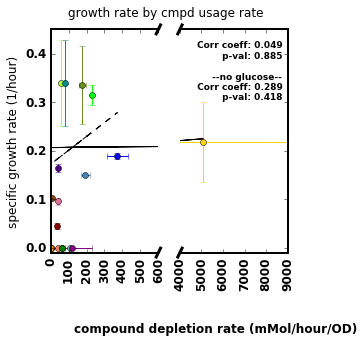

In [23]:
# quick and dirty way to make new figure for the figure with outlier

plots = ['3B10', '9B05', 'L13']

for i, name in enumerate(plots):
    if i == 0:
        f, (ax, ax2) = plt.subplots(1, 2, sharey=True)

        #reorder percent table
        percent = []
        for k, comp in enumerate(thalf.index):
            for kk, comp2 in enumerate(pct.index):
                if comp.replace(' Results Final Conc.', '') == 'glucose':
                    percent.append(0)
                    break
                elif comp.replace(' Results Final Conc.', '') == comp2:
                    percent.append(pct.iloc[kk,i])

        #growth rate on individual compounds
        growth = df[name]
        growth_err = dfstderr[name]

        #max compound usage rate in mixed conditions
        cmprate = maxrate[name[:4]]# / 1000
        cmprate_err = maxrate_stderr[name[:4]]# / 1000

        #turn all nan into 0, for plotting
        growth_zed = growth.fillna(0)

        #to correlate max compound usage rate with growth rate
        c_growth = growth[np.argwhere(~np.isnan(growth)).flatten()]
        c_cmprate = cmprate[np.argwhere(~np.isnan(growth)).flatten()]
        f.suptitle('growth rate by cmpd usage rate')
        f.text(0.2, -0.15, 'compound depletion rate (mMol/hour/OD)')
        for j, blah in enumerate(Th):
            ax.errorbar(cmprate[j], growth_zed[j], 
                         xerr = cmprate_err[j], yerr = growth_err[j], 
                         fmt = 'o', color = colors[j], ecolor = colors[j])
            ax2.errorbar(cmprate[j], growth_zed[j], 
                         xerr = cmprate_err[j], yerr = growth_err[j], 
                         fmt = 'o', color = colors[j], ecolor = colors[j])
        #get pearson correlation coefficient [0] and p-value [1]
        r_gcmp = stats.pearsonr(c_cmprate, c_growth)

        #make the trendline
        z = np.polyfit(c_cmprate, c_growth, 1)
        #convert to mx + b
        p = np.poly1d(z)
        #plot it
        ax.plot(c_cmprate, p(c_cmprate), color = get_col(r_gcmp[1]))
        ax2.plot(c_cmprate, p(c_cmprate), color = get_col(r_gcmp[1]))

        #re-calculate pearson after excluding glucose

        #first drop glucose
#         print c_cmprate
#         print c_growth
        new_cmprate = c_cmprate.drop('glucose Results Final Conc.')
        new_growth = c_growth.drop(8)
#         print new_cmprate
#         print new_cmprate.values
#         print new_cmprate.values.tolist()
#         print new_growth
#         print new_growth.values
#         print new_growth.values.tolist()

        #get pearson correlation coefficient [0] and p-value [1]
        r_gcmp2 = stats.pearsonr(new_cmprate, new_growth)
        #make the trendline
        z2 = np.polyfit(new_cmprate, new_growth, 1)
        #convert to mx + b
        p2 = np.poly1d(z2)
        #plot it
        ax.plot(new_cmprate, p2(new_cmprate), color = get_col(r_gcmp2[1]), linestyle = '--')
        ax2.plot(new_cmprate, p2(new_cmprate), color = get_col(r_gcmp2[1]), linestyle = '--')
        ax2.text(0.95, 0.95,
             'Corr coeff: %.3f\n p-val: %.3f\n\n --no glucose--\n Corr coeff: %.3f\n p-val: %.3f' 
                %(r_gcmp[0], r_gcmp[1], r_gcmp2[0], r_gcmp2[1]),
            horizontalalignment = 'right', verticalalignment = 'top', transform = ax2.transAxes, fontsize=9)
        
        ax.set_xlim(0,600)
        ax2.set_xlim(4000,)
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
        for tick in ax2.get_xticklabels():
            tick.set_rotation(90)
        ax.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax.yaxis.tick_left()
        ax.tick_params('y', labelright='off', which='both')
        ax2.yaxis.tick_right()
        for tick in ax2.get_yticklabels():
            tick.set_visible(False)
        d = .02  # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth=3)
        ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)        # top-right diagonal
        ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-right diagonal

        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-right diagonal
        ax.set_ylabel('specific growth rate (1/hour)')
        ax.set_ylim(-0.01,)
        ax2.set_ylim(-0.01,)
f.set_size_inches(4.25,4)
f.savefig('../Figures/Bc_cmpd_cdw_growth_rate_broken_axes.pdf')